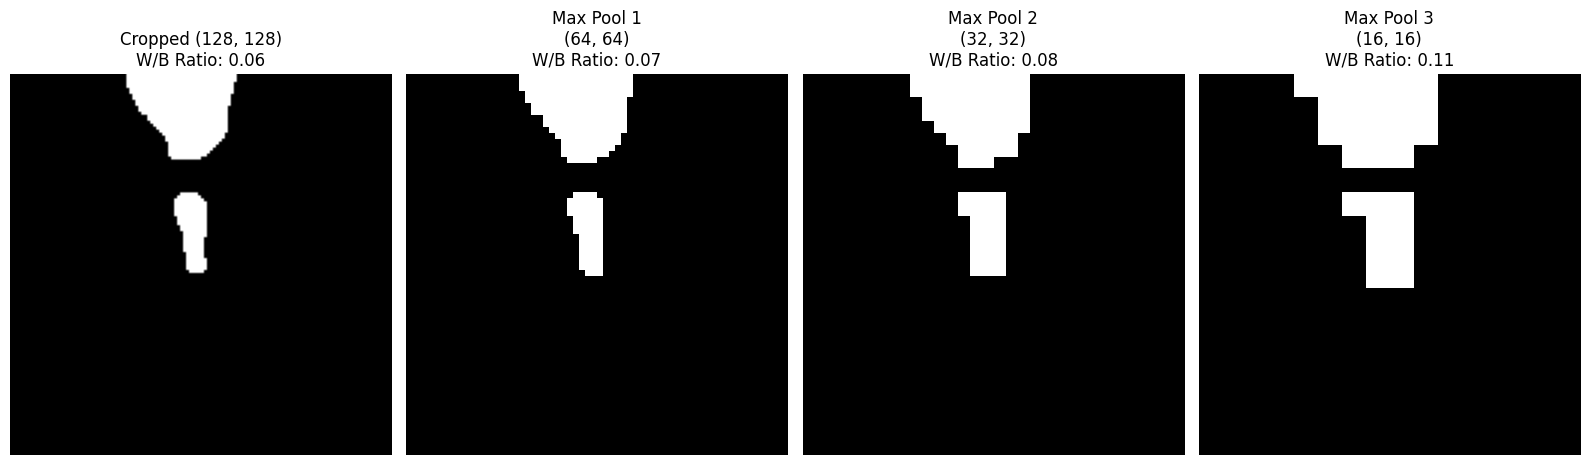

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def load_image(file_path):
    return np.load(file_path)

def center_crop(image, size):
    h, w = image.shape
    top = (h - size) // 2
    left = (w - size) // 2
    return image[top:top+size, left:left+size]

def max_pool(image, pool_size):
    tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).float()
    pooled = F.max_pool2d(tensor, kernel_size=pool_size, stride=pool_size)
    return pooled.squeeze().numpy()

def white_to_black_ratio(image):
    white_pixels = np.sum(image > 0.5)
    black_pixels = np.sum(image <= 0.5)
    return white_pixels / (black_pixels+white_pixels) if black_pixels > 0 else float('inf')

def plot_max_pooling(image, num_iterations=3, pool_size=(2, 2), crop_size=128):
    cropped_image = center_crop(image, crop_size)
    
    fig, axes = plt.subplots(1, num_iterations + 1, figsize=(4 * (num_iterations + 1), 10))
    
    ratio = white_to_black_ratio(cropped_image)
    axes[0].imshow(cropped_image, cmap='gray')
    axes[0].set_title(f'Cropped {cropped_image.shape}\nW/B Ratio: {ratio:.2f}')
    axes[0].axis('off')
    
    current_image = cropped_image
    for i in range(num_iterations):
        current_image = max_pool(current_image, pool_size)
        ratio = white_to_black_ratio(current_image)
        axes[i + 1].imshow(current_image, cmap='gray')
        axes[i + 1].set_title(f'Max Pool {i + 1}\n{current_image.shape}\nW/B Ratio: {ratio:.2f}')
        axes[i + 1].axis('off')
        
        axes[i + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Main execution
if __name__ == "__main__":
    image_path = "/kaggle/input/ch4net-dataset/data/test/label/pos/1020.npy"  # Replace with your .npy file path
    image = load_image(image_path)
    plot_max_pooling(image)

In [2]:
import sys
from PIL import Image

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from glob import glob
import numpy as np
import torch
from random import shuffle
import random
from numpy import random as npr
import pandas as pd
import imageio
from PIL import Image


class MethaneLoader(DataLoader):

    def __init__(self, device, mode, plume_id, red=False, alli=False, channels=12):
        self.device = device
        self.mode = mode
        self.reduce = red
        self.channels = channels

        if mode == "train":
            persist = False
        else:
            persist = True
        
        if plume_id is not None:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/*/{}.npy".format(mode, plume_id)))
#             self.neg_labels = sorted(
#                 glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/{}.npy".format(mode, plume_id)))
            self.neg_labels = []
        else:
            self.pos_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/pos/*.npy".format(mode)))
            self.neg_labels = sorted(
                glob("/kaggle/input/ch4net-dataset/data/{}/label/neg/*.npy".format(mode)))

        self.labels = self.pos_labels+self.neg_labels  # None
        
        if not alli:
            self.sample_labels_and_combine(persist=persist)

    def sample_labels_and_combine(self, persist=False):
        """
        Sample a subset of negative labels for each epoch
        """
        # if self.mode == "test":
        if self.mode in ["val"]:
            self.labels = self.pos_labels+self.neg_labels
        else:
            if persist:
                random.seed(555)

            shuffle(self.neg_labels)
            self.labels = self.pos_labels + \
                self.neg_labels[:len(self.pos_labels)]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):

        f = self.labels[index]
        # print(f)

        plume_id = int(f.split("/")[-1].split(".")[0])
        # print(plume_id)

        target = np.load(f)
        context = np.load(
            "/kaggle/input/ch4net-dataset/data/{}/s2/{}.npy".format(self.mode, plume_id))

        if self.channels == 2:
            context = context[..., 10:]
        if self.channels == 5:
            context = np.concatenate(
                [context[..., 1:4], context[..., 10:]], axis=-1)
        
        if self.mode == "train":
            # rotate by 90, 180, 270 degrees
            degrees = npr.choice([0, 90, 180, 270])
            context = np.rot90(context, k=degrees//90)
            target = np.rot90(target, k=degrees//90)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=0)
                target = np.flip(target, axis=0)
            if npr.rand() > 0.5:
                context = np.flip(context, axis=1)
                target = np.flip(target, axis=1)

        # Crop to centre
        # x_c = target.shape[0]//2
        # y_c = target.shape[1]//2
        s = 64

        if self.mode == "train":
            rng = npr.RandomState()
            mid_loc_x = rng.randint(s, target.shape[0]-s)
            mid_loc_y = rng.randint(s, target.shape[1]-s)

        else:
            mid_loc_x = target.shape[0]//2
            mid_loc_y = target.shape[1]//2

        target = target[mid_loc_x-s:mid_loc_x+s,
                        mid_loc_y-s: mid_loc_y+s]

        context = context[mid_loc_x-s:mid_loc_x+s,
                          mid_loc_y-s: mid_loc_y+s, :]

        ### These are not defined before and not necessary for training. 
        ### But these are used in evaluation outputs
#         diff_img = np.array(diff_img[mid_loc_x-s:mid_loc_x+s,
#                                      mid_loc_y-s:mid_loc_y+s, :])
#         diff_img_g = np.array(diff_img_g[mid_loc_x-s:mid_loc_x+s,
#                                          mid_loc_y-s:mid_loc_y+s])
#         rgb_img = np.array(rgb_img[mid_loc_x-s:mid_loc_x+s,
#                                    mid_loc_y-s:mid_loc_y+s, :])

        if self.reduce:
            target = np.array([np.int(target.any())])

        # if self.mode == "test":
            # print("Plume ID: {}, date: {}".format(plume_id, date))

        d = {"pred": torch.from_numpy(context.copy()).float().to(self.device).permute(2, 0, 1)/255,
             "target": torch.from_numpy(target.copy()).float().to(self.device)}
        
        # Print the size of the image tensor
#         print("Image tensor size (context):", d["pred"].size())
#         print("Image tensor size (target):", d["target"].size())

        return d

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """
    Base MLP module with ReLU activation
    Parameters:
    -----------
    in_channels: Int
        Number of input channels
    out_channels: Int
        Number of output channels
    h_channels: Int
        Number of hidden channels
    h_layers: Int
        Number of hidden layers
    """

    def __init__(self, 
                in_channels, 
                out_channels, 
                h_channels=64,
                h_layers=4):

        super().__init__()

        def hidden_block(h_channels):
            h = nn.Sequential(
            nn.Linear(h_channels, h_channels),
            nn.ReLU())
            return h

        # Model
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.ReLU(),
            *[hidden_block(h_channels) for _ in range(h_layers)],
            nn.Linear(h_channels, out_channels) 
        )

    def forward(self, x):
        return self.mlp(x)

class Unet(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 div_factor=8,
                 prob_output=True,
                 class_output=False

    ):
        super(Unet, self).__init__()

        self.n_channels = in_channels
        self.bilinear = True
        self.sigmoid = nn.Sigmoid()
        self.prob_output = prob_output
        self.class_output = class_output

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )

        def down(in_channels, out_channels):
            return nn.Sequential(
                nn.MaxPool2d(2),
                double_conv(in_channels, out_channels)
            )

        class up(nn.Module):
            def __init__(self, in_channels, out_channels, bilinear=True):
                super().__init__()

                if bilinear:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                else:
                    self.up = nn.ConvTranpose2d(in_channels // 2, in_channels // 2,
                                                kernel_size=2, stride=2)

                self.conv = double_conv(in_channels, out_channels)

            def forward(self, x1, x2):
                x1 = self.up(x1)
                # [?, C, H, W]
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]

                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1) ## why 1?
                return self.conv(x)

        self.inc = double_conv(self.n_channels, 64//div_factor)
        self.down1 = down(64//div_factor, 128//div_factor)
        self.down2 = down(128//div_factor, 256//div_factor)
        self.down3 = down(256//div_factor, 512//div_factor)
        self.down4 = down(512//div_factor, 512//div_factor)
        self.up1 = up(1024//div_factor, 256//div_factor)
        self.up2 = up(512//div_factor, 128//div_factor)
        self.up3 = up(256//div_factor, 64//div_factor)
        self.up4 = up(128//div_factor, 128//div_factor)
        self.out = nn.Conv2d(128//div_factor, 1, kernel_size=1)


    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)

        #return self.out(x).permute(0,2,3,1)

        if self.prob_output:
            x = self.out(x)
            return self.sigmoid(x).permute(0,2,3,1)
        else:
            return self.out(x).permute(0,2,3,1)

In [4]:
import torch
import torch.nn as nn

class conv_block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True))

    def forward(self, x):
        x = self.conv(x)
        return x

class up_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.up(x)
        return x

class Attention_block(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(Attention_block, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        out = x * psi
        return out

class UNet_Attention(nn.Module):
    def __init__(self, img_ch=12, output_ch=1):
        super(UNet_Attention, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4, n1 * 8, n1 * 16]

        self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(img_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])
        self.Conv4 = conv_block(filters[2], filters[3])
        self.Conv5 = conv_block(filters[3], filters[4])

        self.Up5 = up_conv(filters[4], filters[3])
        self.Att5 = Attention_block(F_g=filters[3], F_l=filters[3], F_int=filters[2])
        self.Up_conv5 = conv_block(filters[4], filters[3])

        self.Up4 = up_conv(filters[3], filters[2])
        self.Att4 = Attention_block(F_g=filters[2], F_l=filters[2], F_int=filters[1])
        self.Up_conv4 = conv_block(filters[3], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Att3 = Attention_block(F_g=filters[1], F_l=filters[1], F_int=filters[0])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Att2 = Attention_block(F_g=filters[0], F_l=filters[0], F_int=32)
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv_out_2 = nn.Conv2d(filters[0], output_ch, kernel_size=1, stride=1, padding=0)
        self.Conv_out_3 = nn.Conv2d(filters[1], output_ch, kernel_size=1, stride=1, padding=0)
        self.Conv_out_4 = nn.Conv2d(filters[2], output_ch, kernel_size=1, stride=1, padding=0)
        self.Conv_out_5 = nn.Conv2d(filters[3], output_ch, kernel_size=1, stride=1, padding=0)
        
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        e4 = self.Maxpool3(e3)
        e4 = self.Conv4(e4)

        e5 = self.Maxpool4(e4)
        e5 = self.Conv5(e5)

        d5 = self.Up5(e5)
        
        d5 = self.dropout(d5)

        x4 = self.Att5(g=d5, x=e4)
        d5 = torch.cat((x4, d5), dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        x3 = self.Att4(g=d4, x=e3)
        d4 = torch.cat((x3, d4), dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3, x=e2)
        d3 = torch.cat((x2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2, x=e1)
        d2 = torch.cat((x1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out2 = self.Conv_out_2(d2)
        out3 = self.Conv_out_3(d3)
        out4 = self.Conv_out_4(d4)
        out5 = self.Conv_out_5(d5)

#         return out
        return out2, out3, out4, out5


# Example usage:


model = UNet_Attention(img_ch=12, output_ch=1)
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16
target_tensor = torch.randn(16, 128, 128)
target_tensor = target_tensor.unsqueeze(1)
output = model(input_tensor)

# Check output shape
print(f"Output shape: {output[1].shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

Output shape: torch.Size([16, 1, 64, 64])
Target shape: torch.Size([16, 1, 128, 128])


In [5]:
!mkdir -p /kaggle/working/train_out
!mkdir -p /kaggle/working/eval_out

In [6]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.4 MB/s eta 0:00:00a 0:00:01


In [7]:
import torch
import torch.nn as nn
from torchvision.ops import sigmoid_focal_loss
from monai.losses.hausdorff_loss import HausdorffDTLoss

def loss(pred, target):
#     print(pred.shape, target.shape)
    bce_loss = nn.BCEWithLogitsLoss(reduction="none") 
    ll = bce_loss(pred, target)

    ll = ll.sum(dim=(-2,-1)) #*mask
    return ll.mean()


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.bce_loss = nn.BCEWithLogitsLoss(reduction="none")
    
    def forward(self, pred, target):
        loss = self.bce_loss(pred, target)
        prob = torch.sigmoid(pred)  # Predicted probability
        alpha = torch.where(target == 1, self.alpha, 1 - self.alpha)  # Class balancing factor
        focal_weight = torch.where(target == 1, 1 - prob, prob)  # Focusing weight
        focal_weight = alpha * focal_weight**self.gamma  # Apply alpha and gamma
        focal_loss = focal_weight * loss
        
        focal_loss = focal_loss.sum(dim=(-2,-1)) #*mask
        
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss

    
class MultiScalePoolingLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2, itr=3, ratio=None):
        super(MultiScalePoolingLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.itr = itr
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma)
        self.ratio = torch.tensor(ratio)
    
    def forward(self, pred, target):
        losses = torch.zeros(self.itr)
        if(pred.dim() == 2):
            pred = pred.unsqueeze(0)
            target = target.unsqueeze(0)
        elif(pred.dim() == 3):
            pred = pred.unsqueeze(1)
            target = target.unsqueeze(1)
        for i in range(self.itr):
            losses[i] = self.focal_loss(pred, target)
            pred = F.max_pool2d(pred, kernel_size=2, stride=2)
            target = F.max_pool2d(target, kernel_size=2, stride=2)
        
        if self.ratio is not None:
            losses = losses * self.ratio
        else:
            losses = losses * 1/self.itr
        
        return torch.sum(losses)

    
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(inputs.size(0), -1)
        targets = targets.view(targets.size(0), -1)
        
        # Compute Dice loss
        intersection = (inputs * targets).sum(dim=1)
        dice_loss = 1 - (2.0 * intersection + smooth) / (inputs.sum(dim=1) + targets.sum(dim=1) + smooth)

        # Compute BCE loss
        BCE = F.binary_cross_entropy(inputs, targets, reduction='none')
        BCE = BCE.mean(dim=1)

        # Combine Dice and BCE losses
        Dice_BCE = BCE + dice_loss

        return Dice_BCE.mean()

    
class HausdorffDT_Loss(nn.Module):
    def __init__(self):
        super(HausdorffDT_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='mean', sigmoid=True)
        self.focal_loss = FocalLoss

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        return self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))

    
class HausdorffDT_Focal_Loss(nn.Module):
    def __init__(self, focal_weight = 0.65):
        super(HausdorffDT_Focal_Loss, self).__init__()
        self.hd_loss = HausdorffDTLoss(reduction='none', sigmoid=True)
        self.focal_loss = FocalLoss(alpha=0.75, gamma=2.0, reduction='none')
        self.focal_weight = focal_weight

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or equivalent activation layer
        hl = self.hd_loss(inputs.unsqueeze(1), targets.unsqueeze(1))
        fl = self.focal_loss(inputs, targets)
        final_loss = self.focal_weight * torch.squeeze(fl) + (1-self.focal_weight) * torch.squeeze(hl)
        return torch.mean(final_loss)
    
    
class GuidedLoss(nn.Module):
    def __init__(self):
        super(GuidedLoss, self).__init__()
        self.focal_loss_4 = FocalLoss(alpha=.75, gamma=4, reduction='none')
        self.focal_loss_3 = FocalLoss(alpha=.7, gamma=3.3, reduction='none')
        self.focal_loss_2 = FocalLoss(alpha=.65, gamma=2.5, reduction='none')
        self.focal_loss_1 = FocalLoss(alpha=.6, gamma=1.7, reduction='none')
        self.layer_weights = torch.tensor([0.5, 0.2, 0.2, 0.1])

    def forward(self, pred, target):
        in_layer_4, in_layer_3, in_layer_2, in_layer_1 = pred
        device = in_layer_4.device
    
        f_4 = self.focal_loss_4(in_layer_4, target)

        target_3 = F.max_pool2d(target, kernel_size=2, stride=2)
        f_3 = self.focal_loss_3(in_layer_3, target_3)

        target_2 = F.max_pool2d(target_3, kernel_size=2, stride=2)
        f_2 = self.focal_loss_2(in_layer_2, target_2)

        target_1 = F.max_pool2d(target_2, kernel_size=2, stride=2)
        f_1 = self.focal_loss_1(in_layer_1, target_1)

        focal_loss_tensor = torch.stack([f_4, f_3, f_2, f_1], dim=0).to(device)
        weighted_loss_tensor = focal_loss_tensor * self.layer_weights.view(4, 1).to(device)
#         print(weighted_loss_tensor.shape)
        summed_tensor = weighted_loss_tensor.sum(dim=1)
#         print(summed_tensor.shape)
        final_loss = summed_tensor.sum(axis=0)
        
        return final_loss
    
    
model = UNet_Attention(img_ch=12, output_ch=1)
input_tensor = torch.randn(16, 12, 128, 128)  # Example batch size of 16
target_tensor = torch.randn(16, 128, 128)
output = model(input_tensor)
print(output[0].shape)
output = tuple(np.squeeze(o) for o in output)
print(output[0][0].shape)

# Check output shape
print(f"Output shape: {output[1].shape}")  # Should be [16, 1, 128, 128]
print(f"Target shape: {target_tensor.shape}")  # Should be [16, 1, 128, 128]

guided_loss = GuidedLoss()
print(guided_loss(tuple(np.squeeze(o) for o in output), target_tensor))

2024-09-14 10:14:24.743939: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-14 10:14:24.744044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-14 10:14:24.872848: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


torch.Size([16, 1, 128, 128])
torch.Size([128, 128])
Output shape: torch.Size([16, 64, 64])
Target shape: torch.Size([16, 128, 128])
tensor(3733.6057, grad_fn=<SumBackward1>)


In [8]:
from matplotlib import pyplot as plt
import torch
import scipy
import numpy as np
from tqdm import tqdm
from torch import autograd
from torch.utils.data import DataLoader
# from loader import *


class Trainer():
    """
    Training class for the neural process models
    """

    def __init__(self,
                 model,
                 train_loader,
                 val_loader,
                 train_dataset,
                 loss_function,
                 save_path,
                 learning_rate):

        # Model and data
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.train_dataset = train_dataset
        self.save_path = save_path

        # Training parameters
        self.opt = torch.optim.Adam(model.parameters(), lr=learning_rate)
        self.loss_function = loss_function
        self.sched = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.opt, mode='min', factor=0.5, patience=7, verbose=True)

        # Losses
        self.losses = []
        self.mIoUs = []

    def plot_losses(self):
        """
        Plot losses and IoUs in same figure
        """
        
        fig, ax1 = plt.subplots()

        color = 'tab:red'
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss', color=color)
        ax1.plot(self.losses, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('mIoU', color=color)
        ax2.plot(self.mIoUs, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        plt.show()

    def _unravel_to_numpy(self, x):
        return x.view(-1).detach().cpu().numpy()

    def eval_epoch(self, verbose=False):

        self.model.eval()
        lf = []
        ious = []

        def calculate_iou(pred, target):
            eps = 1e-6
            # convert to sigmoid then to binary
            pred = F.sigmoid(pred)
            pred = (pred > 0.5).float()
            target = target.float()
            
            return (torch.sum(pred * target) + eps) / (torch.sum(pred + target) + eps)
        
        with torch.no_grad():
            for task in self.val_loader:

                out = self.model(task["pred"])
                lf.append(self.loss_function(tuple(np.squeeze(o) for o in out), task["target"]))
                ious.append(calculate_iou(out[0], task["target"]))

        # Get loss function
        log_loss = torch.mean(torch.tensor(lf))
        print("- Log loss: {}".format(log_loss))
        mIoU = torch.mean(torch.tensor(ious))
        print("- mIoU: {}".format(mIoU))

        return log_loss, mIoU

    def train(self, n_epochs=100):

        # Init progress bar
        best_loss = 100000
        best_model_state_dict = None
        best_opt_state_dict = None
        i = 1

        for epoch in range(n_epochs):

            autograd.set_detect_anomaly(True)

            print("Training epoch {}".format(epoch))

            if epoch < 500:
                self.model.train()
                self.train_dataset.sample_labels_and_combine()
                self.train_loader = DataLoader(self.train_dataset,
                                               batch_size=16,
                                               shuffle=True)

            with tqdm(self.train_loader, unit="batch") as tepoch:
                for task in tepoch:

                    out = self.model(task["pred"])

                    # print("loss")
                    loss = self.loss_function(tuple(np.squeeze(o) for o in out), task["target"])

                    loss.backward()
                    self.opt.step()
                    self.opt.zero_grad()
                    # print("out")
                    tepoch.set_postfix(loss=loss.item())
                epoch_loss, mIoU = self.eval_epoch(verbose=False)
                self.sched.step(epoch_loss)
#                 print(self.sched.get_last_lr())

            if np.logical_or(epoch_loss <= best_loss, epoch >= 1000):
                best_model_state_dict = self.model.state_dict()
                best_opt_state_dict = self.opt.state_dict()
                best_loss = epoch_loss

            self.losses.append(epoch_loss)
            self.mIoUs.append(mIoU)

            # checkpoint
            if i % 10 == 0 or i == n_epochs:
                np.save(self.save_path+"losses.npy", np.array(self.losses))
                self.plot_losses()

                torch.save({
                    # 'epoch': epoch,
                    'model_state_dict': best_model_state_dict,
                    'optimizer_state_dict': best_opt_state_dict,
                    'loss': best_loss
                }, self.save_path+"final_model".format(epoch))
                
                best_loss = 100000   # pick the best loss in every checkpoint interval (not globally)
            i += 1

        print("Training complete!")

Training epoch 0


100%|██████████| 75/75 [00:55<00:00,  1.36batch/s, loss=667]    


- Log loss: 810.1907958984375
- mIoU: 3.626980833359994e-05
Training epoch 1


100%|██████████| 75/75 [00:31<00:00,  2.36batch/s, loss=619]


- Log loss: 678.19580078125
- mIoU: 0.0009164080256596208
Training epoch 2


100%|██████████| 75/75 [00:30<00:00,  2.43batch/s, loss=550]


- Log loss: 668.51220703125
- mIoU: 0.00022787036141380668
Training epoch 3


100%|██████████| 75/75 [00:29<00:00,  2.53batch/s, loss=560]


- Log loss: 620.20556640625
- mIoU: 1.9017208614968695e-05
Training epoch 4


100%|██████████| 75/75 [00:29<00:00,  2.50batch/s, loss=426]


- Log loss: 614.406005859375
- mIoU: 2.1914924736021746e-11
Training epoch 5


100%|██████████| 75/75 [00:28<00:00,  2.64batch/s, loss=676]    


- Log loss: 621.5161743164062
- mIoU: 1.4088490388530772e-05
Training epoch 6


100%|██████████| 75/75 [00:26<00:00,  2.87batch/s, loss=486]e+3]


- Log loss: 598.27978515625
- mIoU: 0.011429126374423504


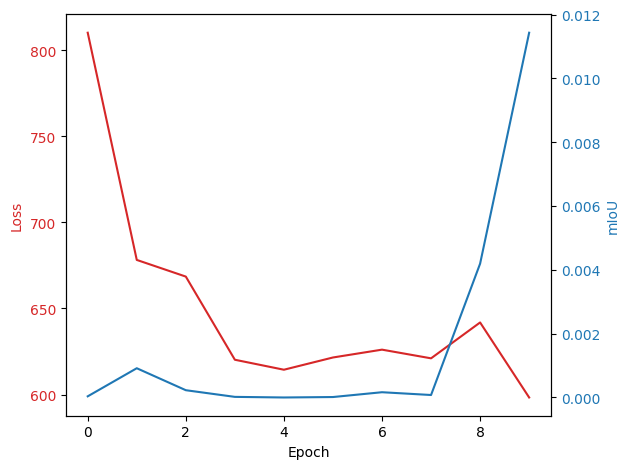

Training epoch 10


100%|██████████| 75/75 [00:25<00:00,  2.96batch/s, loss=415]    


- Log loss: 568.4653930664062
- mIoU: 0.0032198112457990646
Training epoch 11


100%|██████████| 75/75 [00:25<00:00,  2.93batch/s, loss=464]


- Log loss: 560.6871948242188
- mIoU: 0.0061002448201179504
Training epoch 12


100%|██████████| 75/75 [00:24<00:00,  3.03batch/s, loss=437]


- Log loss: 499.52093505859375
- mIoU: 0.01374570932239294
Training epoch 13


100%|██████████| 75/75 [00:24<00:00,  3.03batch/s, loss=442]


- Log loss: 507.14990234375
- mIoU: 0.007713785395026207
Training epoch 14


100%|██████████| 75/75 [00:24<00:00,  3.10batch/s, loss=321]


- Log loss: 533.7500610351562
- mIoU: 0.007477924693375826
Training epoch 15


100%|██████████| 75/75 [00:23<00:00,  3.20batch/s, loss=361]


- Log loss: 476.8428649902344
- mIoU: 0.0156867653131485
Training epoch 16


100%|██████████| 75/75 [00:23<00:00,  3.22batch/s, loss=431]    


- Log loss: 540.4266967773438
- mIoU: 0.014284074306488037
Training epoch 17


100%|██████████| 75/75 [00:23<00:00,  3.23batch/s, loss=558]


- Log loss: 490.86334228515625
- mIoU: 0.019255222752690315
Training epoch 18


100%|██████████| 75/75 [00:23<00:00,  3.16batch/s, loss=406]


- Log loss: 487.6975402832031
- mIoU: 0.016494253650307655
Training epoch 19


100%|██████████| 75/75 [00:22<00:00,  3.31batch/s, loss=493]


- Log loss: 566.643798828125
- mIoU: 0.01188706886023283


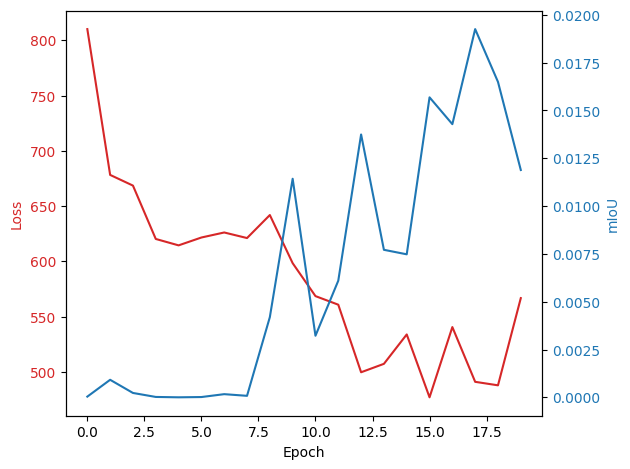

Training epoch 20


100%|██████████| 75/75 [00:22<00:00,  3.31batch/s, loss=400]


- Log loss: 525.6137084960938
- mIoU: 0.006298262160271406
Training epoch 21


100%|██████████| 75/75 [00:21<00:00,  3.44batch/s, loss=330]


- Log loss: 487.11529541015625
- mIoU: 0.023915456607937813
Training epoch 22


100%|██████████| 75/75 [00:21<00:00,  3.42batch/s, loss=500]


- Log loss: 560.6798095703125
- mIoU: 0.012567541562020779
Training epoch 23


100%|██████████| 75/75 [00:21<00:00,  3.42batch/s, loss=405]


- Log loss: 460.38763427734375
- mIoU: 0.023506542667746544
Training epoch 24


100%|██████████| 75/75 [00:21<00:00,  3.46batch/s, loss=393]


- Log loss: 444.8601989746094
- mIoU: 0.014858578331768513
Training epoch 25


100%|██████████| 75/75 [00:21<00:00,  3.43batch/s, loss=299]


- Log loss: 500.7589416503906
- mIoU: 0.011901933699846268
Training epoch 26


100%|██████████| 75/75 [00:21<00:00,  3.51batch/s, loss=359]


- Log loss: 430.9227294921875
- mIoU: 0.027588993310928345
Training epoch 27


100%|██████████| 75/75 [00:21<00:00,  3.49batch/s, loss=278]


- Log loss: 405.4774475097656
- mIoU: 0.028065383434295654
Training epoch 28


100%|██████████| 75/75 [00:21<00:00,  3.56batch/s, loss=383]


- Log loss: 453.55987548828125
- mIoU: 0.02367055043578148
Training epoch 29


100%|██████████| 75/75 [00:21<00:00,  3.54batch/s, loss=334]


- Log loss: 435.354736328125
- mIoU: 0.023463575169444084


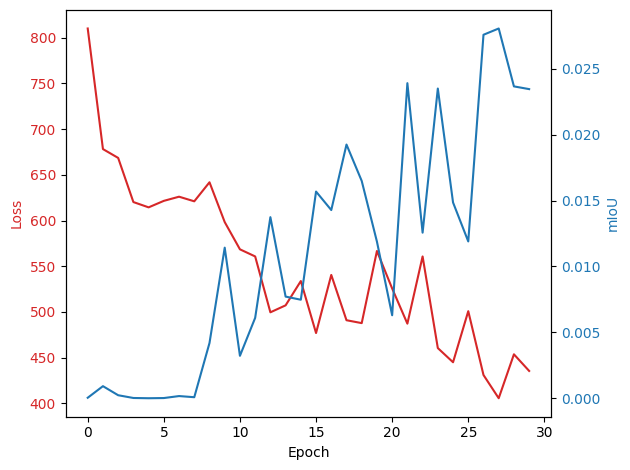

Training epoch 30


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=240]


- Log loss: 408.9300842285156
- mIoU: 0.025848597288131714
Training epoch 31


100%|██████████| 75/75 [00:20<00:00,  3.62batch/s, loss=264]


- Log loss: 499.493408203125
- mIoU: 0.014339286834001541
Training epoch 32


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=238]


- Log loss: 409.131591796875
- mIoU: 0.035117536783218384
Training epoch 33


100%|██████████| 75/75 [00:20<00:00,  3.59batch/s, loss=357]


- Log loss: 409.07110595703125
- mIoU: 0.027052640914916992
Training epoch 34


100%|██████████| 75/75 [00:20<00:00,  3.66batch/s, loss=285]


- Log loss: 463.0987548828125
- mIoU: 0.0238375011831522
Training epoch 35


100%|██████████| 75/75 [00:20<00:00,  3.60batch/s, loss=422]


- Log loss: 433.64996337890625
- mIoU: 0.028306609019637108
Epoch 00036: reducing learning rate of group 0 to 5.0000e-05.
Training epoch 36


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=437]


- Log loss: 387.58447265625
- mIoU: 0.03191763162612915
Training epoch 37


100%|██████████| 75/75 [00:20<00:00,  3.67batch/s, loss=252]


- Log loss: 381.5519104003906
- mIoU: 0.027876462787389755
Training epoch 38


100%|██████████| 75/75 [00:20<00:00,  3.74batch/s, loss=527]


- Log loss: 352.025146484375
- mIoU: 0.037034519016742706
Training epoch 39


100%|██████████| 75/75 [00:20<00:00,  3.71batch/s, loss=258]


- Log loss: 359.596923828125
- mIoU: 0.03465636819601059


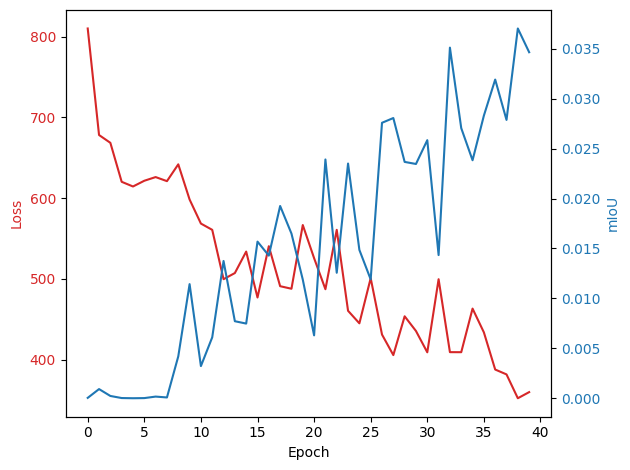

Training epoch 40


100%|██████████| 75/75 [00:20<00:00,  3.71batch/s, loss=230]


- Log loss: 406.30609130859375
- mIoU: 0.029657306149601936
Training epoch 41


100%|██████████| 75/75 [00:19<00:00,  3.75batch/s, loss=214]


- Log loss: 351.5431213378906
- mIoU: 0.03584575653076172
Training epoch 42


100%|██████████| 75/75 [00:20<00:00,  3.72batch/s, loss=257]


- Log loss: 356.1288146972656
- mIoU: 0.03474268689751625
Training epoch 43


100%|██████████| 75/75 [00:20<00:00,  3.72batch/s, loss=226]


- Log loss: 334.20733642578125
- mIoU: 0.041079264134168625
Training epoch 44


100%|██████████| 75/75 [00:19<00:00,  3.80batch/s, loss=177]


- Log loss: 347.2528991699219
- mIoU: 0.04199828580021858
Training epoch 45


100%|██████████| 75/75 [00:20<00:00,  3.73batch/s, loss=385]


- Log loss: 389.9721374511719
- mIoU: 0.02973427064716816
Training epoch 46


100%|██████████| 75/75 [00:19<00:00,  3.76batch/s, loss=214]


- Log loss: 359.62200927734375
- mIoU: 0.03870394453406334
Training epoch 47


100%|██████████| 75/75 [00:20<00:00,  3.69batch/s, loss=217]


- Log loss: 377.27850341796875
- mIoU: 0.03676376864314079
Training epoch 48


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=364]


- Log loss: 354.27294921875
- mIoU: 0.03585825115442276
Training epoch 49


100%|██████████| 75/75 [00:20<00:00,  3.69batch/s, loss=223]


- Log loss: 405.0397033691406
- mIoU: 0.0329081155359745


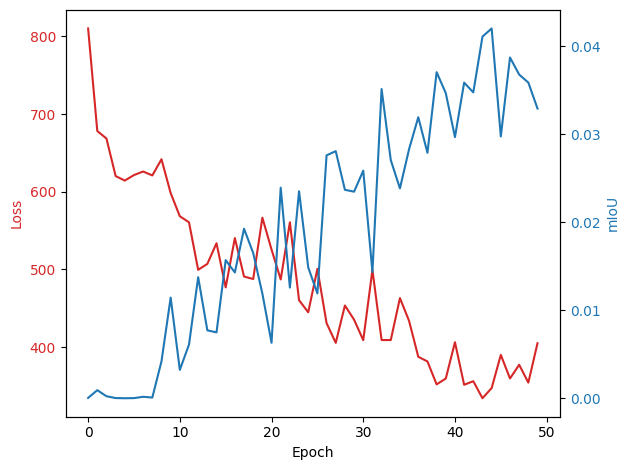

Training epoch 50


100%|██████████| 75/75 [00:20<00:00,  3.61batch/s, loss=347]


- Log loss: 383.31591796875
- mIoU: 0.032160304486751556
Training epoch 51


100%|██████████| 75/75 [00:19<00:00,  3.77batch/s, loss=207]


- Log loss: 412.0179748535156
- mIoU: 0.030521754175424576
Epoch 00052: reducing learning rate of group 0 to 2.5000e-05.
Training epoch 52


100%|██████████| 75/75 [00:19<00:00,  3.75batch/s, loss=237]


- Log loss: 342.112548828125
- mIoU: 0.0345415435731411
Training epoch 53


100%|██████████| 75/75 [00:19<00:00,  3.77batch/s, loss=249]


- Log loss: 353.0309753417969
- mIoU: 0.035360198467969894
Training epoch 54


100%|██████████| 75/75 [00:19<00:00,  3.79batch/s, loss=142]


- Log loss: 350.3417663574219
- mIoU: 0.037156544625759125
Training epoch 55


100%|██████████| 75/75 [00:19<00:00,  3.75batch/s, loss=142]


- Log loss: 339.2935485839844
- mIoU: 0.0361722894012928
Training epoch 56


100%|██████████| 75/75 [00:19<00:00,  3.79batch/s, loss=248]


- Log loss: 343.3497619628906
- mIoU: 0.039056289941072464
Training epoch 57


100%|██████████| 75/75 [00:19<00:00,  3.79batch/s, loss=192]


- Log loss: 352.5499572753906
- mIoU: 0.03873027116060257
Training epoch 58


100%|██████████| 75/75 [00:19<00:00,  3.81batch/s, loss=337]


- Log loss: 338.6611022949219
- mIoU: 0.03855063393712044
Training epoch 59


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=198]


- Log loss: 351.43231201171875
- mIoU: 0.04130123183131218
Epoch 00060: reducing learning rate of group 0 to 1.2500e-05.


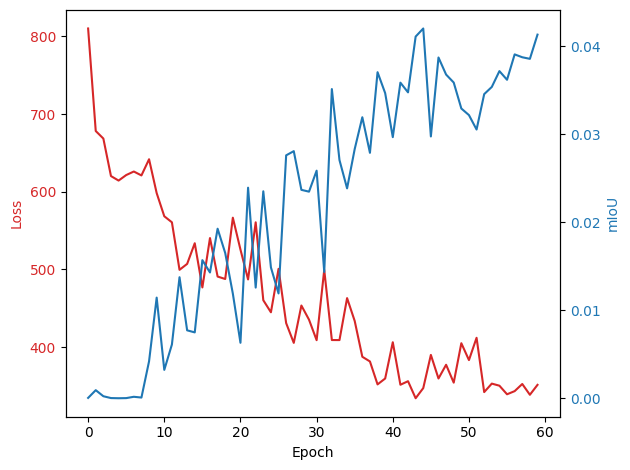

Training epoch 60


100%|██████████| 75/75 [00:19<00:00,  3.81batch/s, loss=234]


- Log loss: 352.87530517578125
- mIoU: 0.03719062730669975
Training epoch 61


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=413]


- Log loss: 330.78759765625
- mIoU: 0.03804495558142662
Training epoch 62


100%|██████████| 75/75 [00:19<00:00,  3.85batch/s, loss=222]


- Log loss: 329.9558410644531
- mIoU: 0.037674326449632645
Training epoch 63


100%|██████████| 75/75 [00:19<00:00,  3.81batch/s, loss=141]


- Log loss: 332.9818115234375
- mIoU: 0.03630382940173149
Training epoch 64


100%|██████████| 75/75 [00:19<00:00,  3.84batch/s, loss=293]


- Log loss: 327.81524658203125
- mIoU: 0.03833157196640968
Training epoch 65


100%|██████████| 75/75 [00:19<00:00,  3.77batch/s, loss=121]


- Log loss: 320.7007141113281
- mIoU: 0.039543792605400085
Training epoch 66


100%|██████████| 75/75 [00:19<00:00,  3.77batch/s, loss=172]


- Log loss: 320.6876525878906
- mIoU: 0.03710918873548508
Training epoch 67


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=223]


- Log loss: 330.47705078125
- mIoU: 0.03993407264351845
Training epoch 68


100%|██████████| 75/75 [00:19<00:00,  3.80batch/s, loss=192]


- Log loss: 320.3504333496094
- mIoU: 0.04063212871551514
Training epoch 69


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=549]


- Log loss: 318.56658935546875
- mIoU: 0.039103999733924866


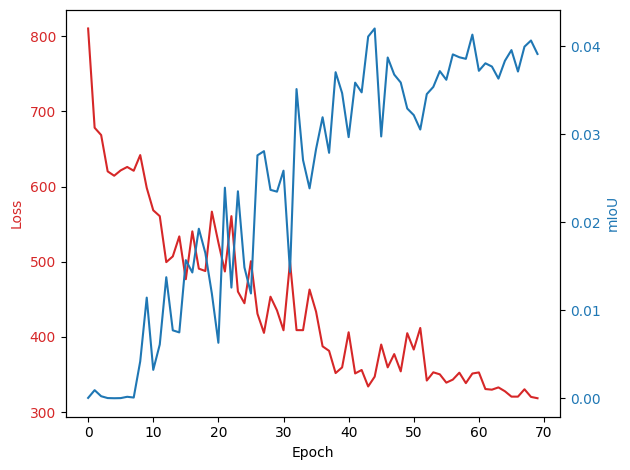

Training epoch 70


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=188]


- Log loss: 314.5015869140625
- mIoU: 0.036515671759843826
Training epoch 71


100%|██████████| 75/75 [00:19<00:00,  3.79batch/s, loss=224]


- Log loss: 327.23760986328125
- mIoU: 0.038270581513643265
Training epoch 72


100%|██████████| 75/75 [00:19<00:00,  3.86batch/s, loss=217]


- Log loss: 322.9751892089844
- mIoU: 0.04022008553147316
Training epoch 73


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=188]


- Log loss: 316.443603515625
- mIoU: 0.038569916039705276
Training epoch 74


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=140]


- Log loss: 317.7389831542969
- mIoU: 0.03924305737018585
Training epoch 75


100%|██████████| 75/75 [00:19<00:00,  3.80batch/s, loss=330]


- Log loss: 315.5386657714844
- mIoU: 0.04147619009017944
Training epoch 76


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=231]


- Log loss: 325.9931945800781
- mIoU: 0.039076708257198334
Training epoch 77


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=259]


- Log loss: 322.5792541503906
- mIoU: 0.041114531457424164
Training epoch 78


100%|██████████| 75/75 [00:19<00:00,  3.80batch/s, loss=255]


- Log loss: 318.45599365234375
- mIoU: 0.03923043981194496
Epoch 00079: reducing learning rate of group 0 to 6.2500e-06.
Training epoch 79


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=160]


- Log loss: 317.344482421875
- mIoU: 0.041344042867422104


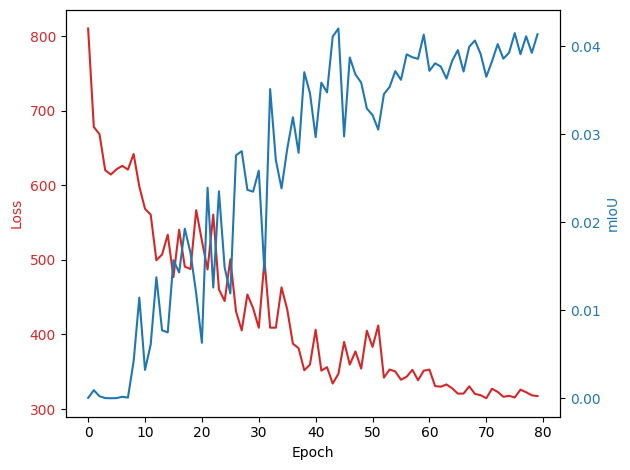

Training epoch 80


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=180]


- Log loss: 310.917724609375
- mIoU: 0.039505161345005035
Training epoch 81


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=491]


- Log loss: 308.06640625
- mIoU: 0.04153026267886162
Training epoch 82


100%|██████████| 75/75 [00:19<00:00,  3.79batch/s, loss=158]


- Log loss: 320.32794189453125
- mIoU: 0.03892001882195473
Training epoch 83


100%|██████████| 75/75 [00:19<00:00,  3.81batch/s, loss=237]


- Log loss: 313.23828125
- mIoU: 0.038057997822761536
Training epoch 84


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=137]


- Log loss: 319.0401916503906
- mIoU: 0.04239143058657646
Training epoch 85


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=164]


- Log loss: 323.5934753417969
- mIoU: 0.03941908851265907
Training epoch 86


100%|██████████| 75/75 [00:19<00:00,  3.81batch/s, loss=179]


- Log loss: 320.5155944824219
- mIoU: 0.040965735912323
Training epoch 87


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=155]


- Log loss: 329.2738037109375
- mIoU: 0.03994239866733551
Training epoch 88


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=129]


- Log loss: 312.4884948730469
- mIoU: 0.04253785312175751
Training epoch 89


100%|██████████| 75/75 [00:19<00:00,  3.81batch/s, loss=158]


- Log loss: 311.294677734375
- mIoU: 0.03997684270143509
Epoch 00090: reducing learning rate of group 0 to 3.1250e-06.


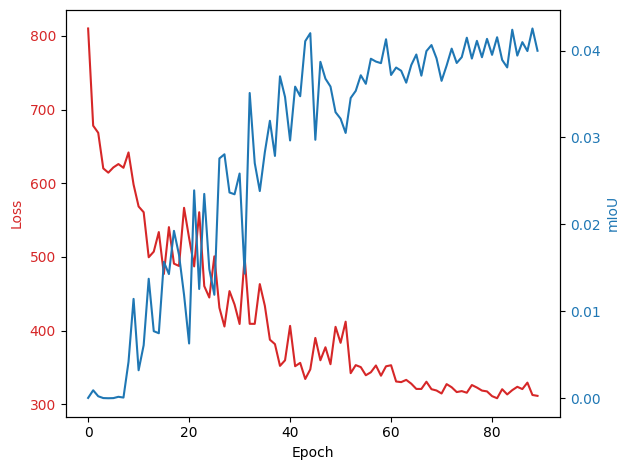

Training epoch 90


100%|██████████| 75/75 [00:19<00:00,  3.84batch/s, loss=325]


- Log loss: 313.7391052246094
- mIoU: 0.03772848844528198
Training epoch 91


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=166]


- Log loss: 310.4127197265625
- mIoU: 0.0409495048224926
Training epoch 92


100%|██████████| 75/75 [00:19<00:00,  3.80batch/s, loss=126]


- Log loss: 312.59027099609375
- mIoU: 0.042010724544525146
Training epoch 93


100%|██████████| 75/75 [00:19<00:00,  3.77batch/s, loss=184]


- Log loss: 314.1294250488281
- mIoU: 0.03984005004167557
Training epoch 94


100%|██████████| 75/75 [00:20<00:00,  3.70batch/s, loss=242]


- Log loss: 316.2469177246094
- mIoU: 0.040932025760412216
Training epoch 95


100%|██████████| 75/75 [00:20<00:00,  3.69batch/s, loss=193]


- Log loss: 304.61053466796875
- mIoU: 0.0411672443151474
Training epoch 96


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=200]


- Log loss: 306.84588623046875
- mIoU: 0.03998531401157379
Training epoch 97


100%|██████████| 75/75 [00:19<00:00,  3.76batch/s, loss=155]


- Log loss: 311.0408935546875
- mIoU: 0.040777336806058884
Training epoch 98


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=212]


- Log loss: 303.84808349609375
- mIoU: 0.042758096009492874
Training epoch 99


100%|██████████| 75/75 [00:20<00:00,  3.73batch/s, loss=164]


- Log loss: 313.0404357910156
- mIoU: 0.040625087916851044


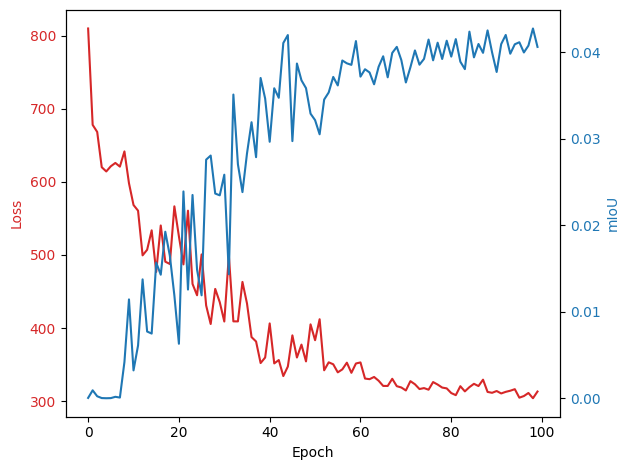

Training epoch 100


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=129]


- Log loss: 313.7642822265625
- mIoU: 0.044329963624477386
Training epoch 101


100%|██████████| 75/75 [00:20<00:00,  3.68batch/s, loss=172]


- Log loss: 307.723876953125
- mIoU: 0.04211963340640068
Training epoch 102


100%|██████████| 75/75 [00:20<00:00,  3.71batch/s, loss=242]


- Log loss: 307.2934875488281
- mIoU: 0.04227285832166672
Training epoch 103


100%|██████████| 75/75 [00:19<00:00,  3.78batch/s, loss=286]


- Log loss: 300.82940673828125
- mIoU: 0.043032530695199966
Training epoch 104


100%|██████████| 75/75 [00:19<00:00,  3.76batch/s, loss=209]


- Log loss: 305.3758239746094
- mIoU: 0.04385567083954811
Training epoch 105


100%|██████████| 75/75 [00:19<00:00,  3.83batch/s, loss=270]


- Log loss: 307.61614990234375
- mIoU: 0.043026216328144073
Training epoch 106


100%|██████████| 75/75 [00:19<00:00,  3.82batch/s, loss=208]


- Log loss: 310.5704345703125
- mIoU: 0.04148807004094124
Training epoch 107


100%|██████████| 75/75 [00:19<00:00,  3.80batch/s, loss=119]


- Log loss: 308.20025634765625
- mIoU: 0.04007496312260628
Training epoch 108


100%|██████████| 75/75 [00:19<00:00,  3.84batch/s, loss=162]


- Log loss: 299.8336181640625
- mIoU: 0.04182447865605354
Training epoch 109


100%|██████████| 75/75 [00:19<00:00,  3.80batch/s, loss=235]


- Log loss: 305.5188293457031
- mIoU: 0.0413033664226532


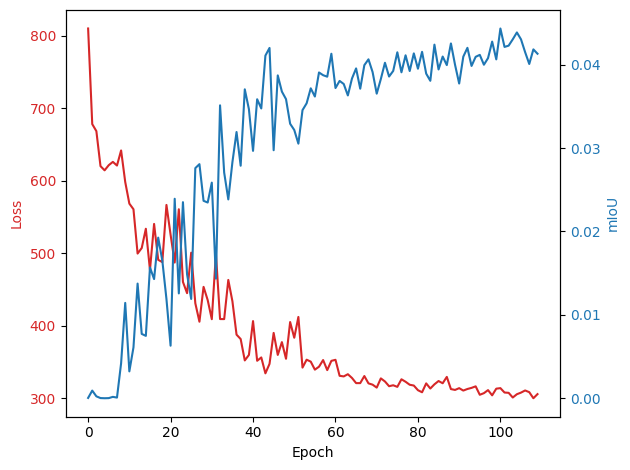

Training complete!


In [9]:
# from models import *
# from trainer import *
# from loader import *
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.multivariate_normal import MultivariateNormal
import sys

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn import DataParallel

#python3 train.py 12 FINAL_12/

# Input arguments
# channels = int(sys.argv[1])
# out_dir = sys.argv[2]

channels = 12
out_dir = '/kaggle/working/train_out/'

# Set up 
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True
device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
model = model.to(device)
model = nn.DataParallel(model)

# Set up loss function
# loss_fn = MultiScalePoolingLoss(alpha=0.75, gamma=0.0, itr=4, ratio=[0.4, 0.2, 0.2, 0.3])
loss_fn = GuidedLoss()

train_dataset = MethaneLoader(device = "cuda", mode="train", plume_id=None, channels=channels)
test_dataset = MethaneLoader(device = "cuda", mode="test", plume_id=None, channels=channels)

#print(train_dataset.__len__())

train_loader = DataLoader(train_dataset, 
                          batch_size = 16, 
                          shuffle = True)

test_loader = DataLoader(test_dataset, 
                          batch_size = 16, 
                          shuffle = True)


# Make the trainer
trainer = Trainer(model,
                  train_loader,
                  test_loader,
                  train_dataset,
                  loss_fn,
                  out_dir,
                  1e-4)

# Train
trainer.train(n_epochs=110)

In [10]:
### for clearing directory
### skip it
#!rm -rf /kaggle/working/*

In [11]:
def visualize(idx):
    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)

    print(image1.shape, image2.shape, image3.shape)

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()

In [12]:
from matplotlib import pyplot as plt
import torch
import numpy as np
from tqdm import tqdm

# from models import *
# from trainer import *
# from loader import *

from torch.utils.data import DataLoader
from glob import glob

# python3 gen_eval_preds.py 12 final_12_all/ final_12_preds/ 0
# in_dir = sys.argv[2]
# out_dir = sys.argv[3]
# channels = int(sys.argv[1])
# alli_yn = bool(int(sys.argv[4]))

in_dir = "/kaggle/working/train_out/"
out_dir = "/kaggle/working/eval_out/"
channels = 12
alli_yn = False

print("Loading losses...")
losses = np.load(in_dir+"losses.npy")
best_epoch = np.argmin(losses)
print('best epoch: ', best_epoch)

device = torch.device('cuda')

# Set up model
model = UNet_Attention(img_ch=channels,
            output_ch=1,
            )
# model = Unet(in_channels=channels,
#             out_channels=1,
#             div_factor=1, 
#             prob_output=False)
# model = Res_UNet_Channel_Attention(img_ch=12, output_ch=1)
model = model.to(device)
model = nn.DataParallel(model)

model.load_state_dict(torch.load(in_dir+"final_model",
                      map_location=torch.device('cuda'))["model_state_dict"])
# model.load_state_dict(torch.load('/kaggle/input/ch4net_attention/pytorch/default/1/final_model',
#                       map_location=torch.device('cuda'))["model_state_dict"])
model.eval()
print()

Loading losses...
best epoch:  108



In [13]:
import torch
import numpy as np

def calculate_iou(pred, target):
    """
    Calculate Intersection over Union (IoU)
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def calculate_accuracy(pred, target):
    """
    Calculate pixel-wise accuracy
    """
    pred = pred > 0  # Convert to binary mask
    target = target > 0  # Convert to binary mask
    correct = np.sum(pred == target)
    total = pred.size
    return correct / total

In [14]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import balanced_accuracy_score

def calculate_metrics(pred, target, epsilon=1e-6):
    """
    Calculate IoU, Accuracy, Recall, Balanced Accuracy, False Positive Rate, and False Negative Rate
    """
    pred = F.sigmoid(torch.tensor(pred)).numpy()
    pred = pred > 0.5 # Convert to binary mask
    target = target > 0  # Convert to binary mask
    
    true_positive = np.sum(np.logical_and(pred, target))
    false_positive = np.sum(np.logical_and(pred, np.logical_not(target)))
    false_negative = np.sum(np.logical_and(np.logical_not(pred), target))
    true_negative = np.sum(np.logical_and(np.logical_not(pred), np.logical_not(target)))
    
    # IoU
    union = np.sum(np.logical_or(pred, target))
    iou = (true_positive + epsilon) / (union + epsilon)
    
    # Accuracy
    total = pred.size
    accuracy = (true_positive + true_negative) / total
    
    # Recall (True Positive Rate)
    recall = (true_positive + epsilon) / (true_positive + false_negative + epsilon)
    
    # False Positive Rate
    fpr = (false_positive + epsilon) / (false_positive + true_negative + epsilon)
    
    # False Negative Rate
    fnr = (false_negative + epsilon) / (false_negative + true_positive + epsilon)
    
    # Balanced Accuracy
#     balanced_acc = balanced_accuracy_score(target.flatten(), pred.flatten())
    balanced_acc = None
    
    return iou, accuracy, recall, balanced_acc, fpr, fnr

# ... [Previous imports and setup code remains the same]

losses = []
ious = []
accuracies = []
recalls = []
balanced_accs = []
fprs = []
fnrs = []

loss_fn = GuidedLoss()

# Iterate over each plume
for i in tqdm(range(250)):
    preds = []
    targets = []

    test_dataset = MethaneLoader(
        device="cuda", mode="val", alli=alli_yn, plume_id=i, channels=channels)

    val_loader = DataLoader(test_dataset,
                            batch_size=64,
                            shuffle=False)

    for batch in val_loader:
        out = model(batch["pred"])
        preds.append(np.squeeze(out[0]).cpu())
        targets.append(np.squeeze(batch["target"]).cpu())
        loss_val = loss_fn(tuple(np.squeeze(o).unsqueeze(0) for o in out), np.squeeze(batch["target"]).unsqueeze(0))
        losses.append(loss_val.item())
        
    if len(preds) > 0:
        preds = torch.concat(preds, dim=0).detach().numpy()
        targets = torch.concat(targets, dim=0).detach().numpy()

        # Calculate metrics for this plume
        iou, accuracy, recall, balanced_acc, fpr, fnr = calculate_metrics(preds, targets)
        
        ious.append(iou)
        accuracies.append(accuracy)
        recalls.append(recall)
        balanced_accs.append(balanced_acc)
        fprs.append(fpr)
        fnrs.append(fnr)
        
        preds = F.sigmoid(torch.tensor(preds)).numpy()
        preds = preds > 0.5 # Convert to binary mask
        np.save(out_dir+f"out_{i}.npy", preds)
        np.save(out_dir+f"target_{i}.npy", targets)

# Calculate and print overall metrics
mean_loss = np.mean(losses)
mean_iou = np.mean(ious)
mean_accuracy = np.mean(accuracies)
mean_recall = np.mean(recalls)
# mean_balanced_acc = np.mean(balanced_accs)
mean_fpr = np.mean(fprs)
mean_fnr = np.mean(fnrs)

print(f"Mean Loss: {mean_loss:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Accuracy: {mean_accuracy:.4f}")
print(f"Mean Recall: {mean_recall:.4f}")
# print(f"Mean Balanced Accuracy: {mean_balanced_acc:.4f}")
print(f"Mean False Positive Rate: {mean_fpr:.4f}")
print(f"Mean False Negative Rate: {mean_fnr:.4f}")

# Save metrics
np.save(out_dir+"metrics.npy", {
    "loss": mean_loss,
    "iou": mean_iou,
    "accuracy": mean_accuracy,
    "recall": mean_recall,
#     "balanced_accuracy": mean_balanced_acc,
    "false_positive_rate": mean_fpr,
    "false_negative_rate": mean_fnr
})

100%|██████████| 250/250 [00:26<00:00,  9.31it/s]

Mean Loss: 25.4457
Mean IoU: 0.5648
Mean Accuracy: 0.9826
Mean Recall: 0.7410
Mean False Positive Rate: 0.0083
Mean False Negative Rate: 0.7731


pos
5.398619017326666


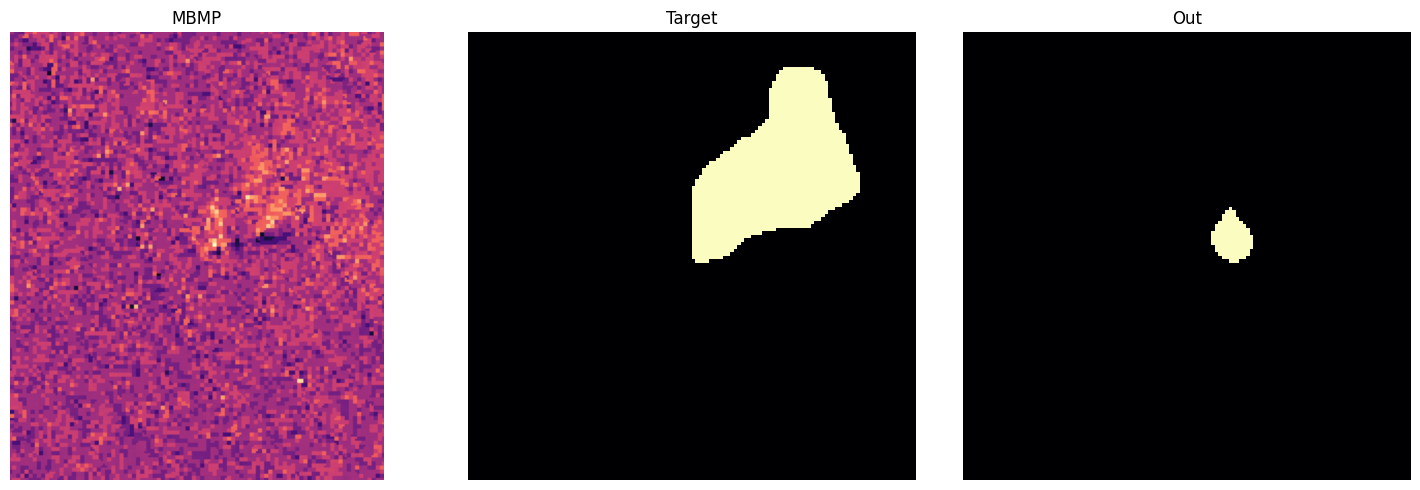

neg
100.0


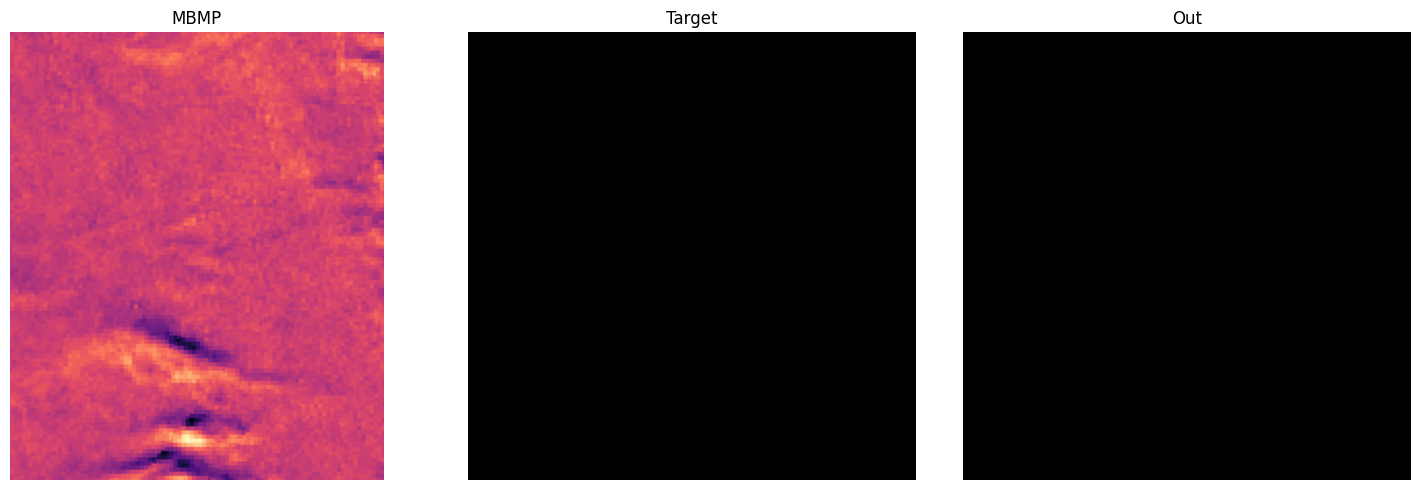

neg
6.369426711022759e-07


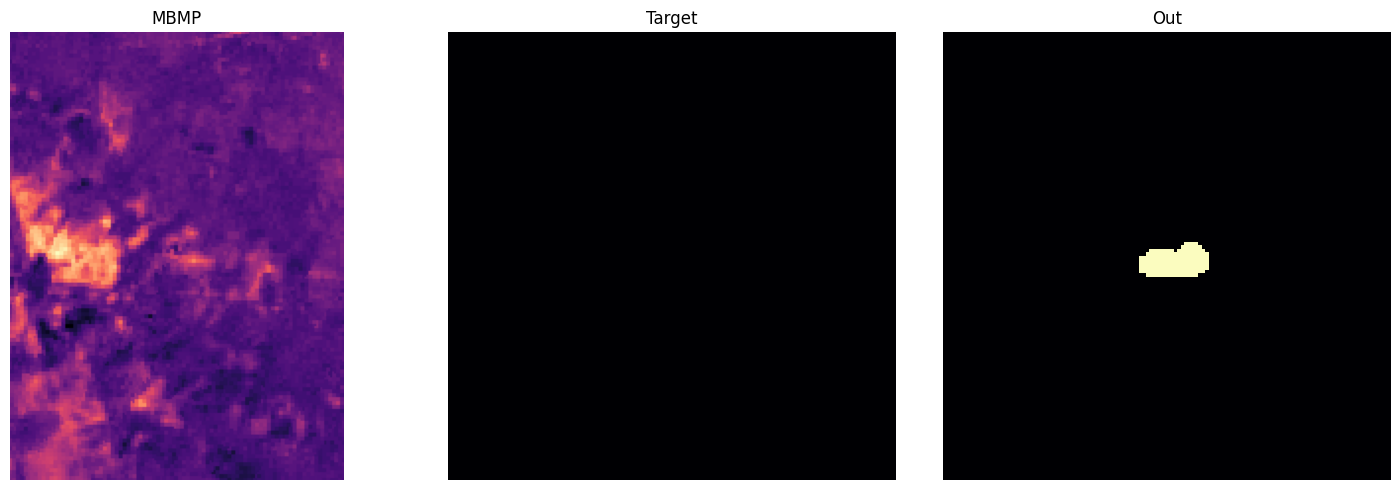

pos
57.875457926892


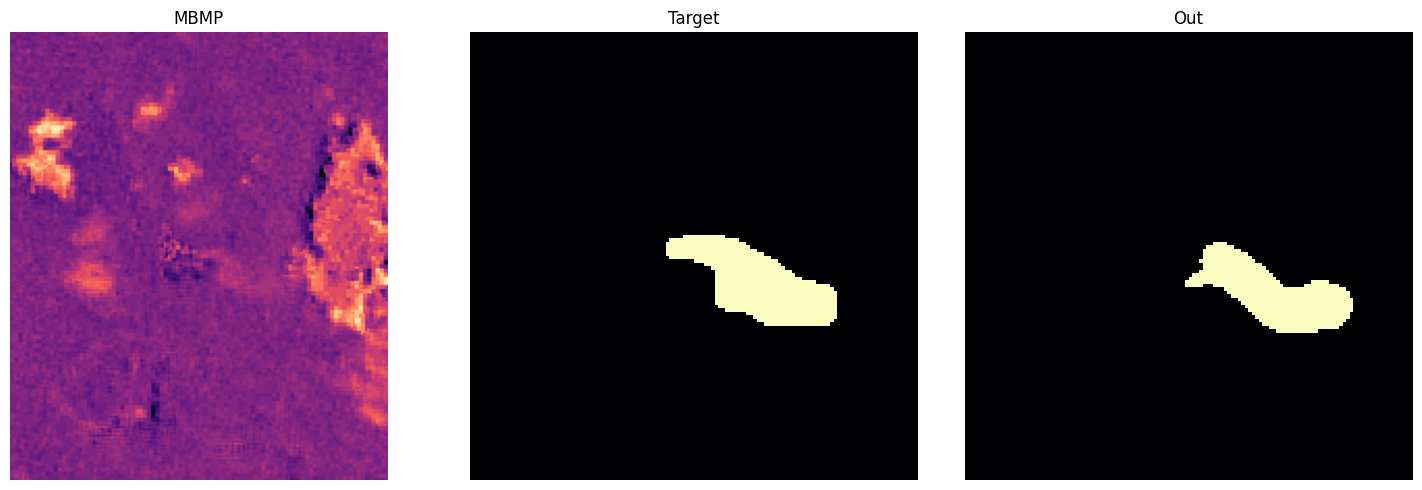

neg
1.923076886094675e-06


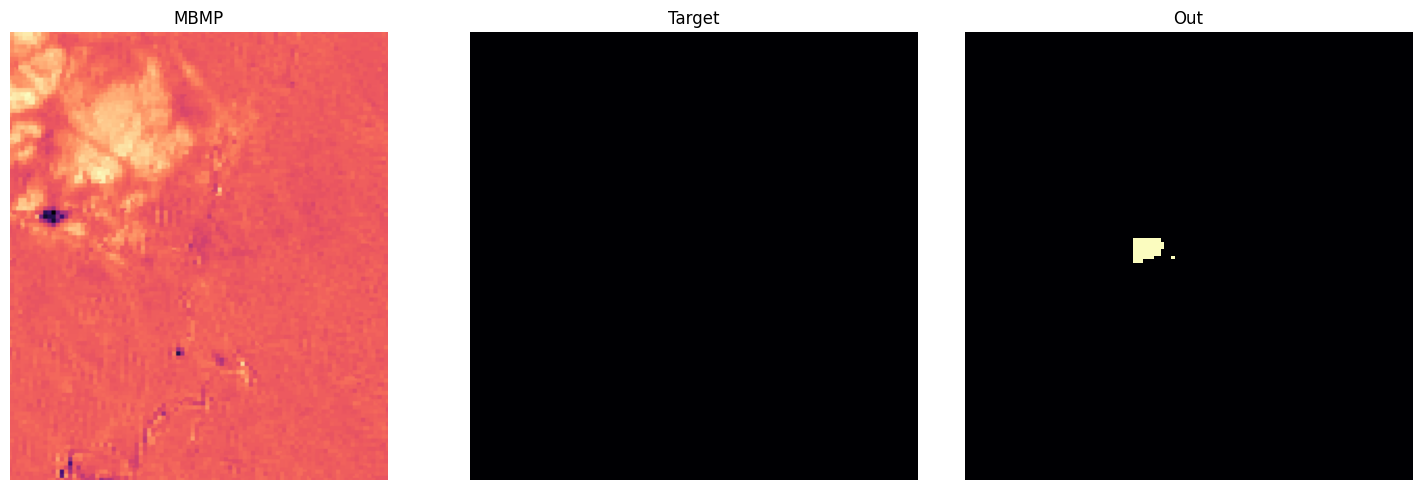

pos
41.22893960234991


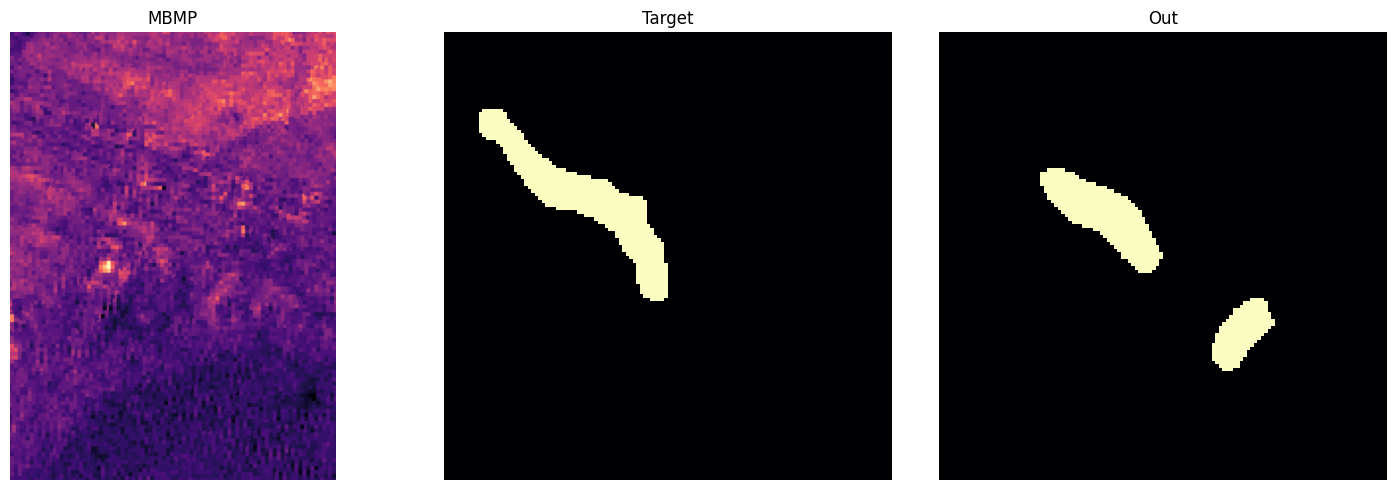

neg
100.0


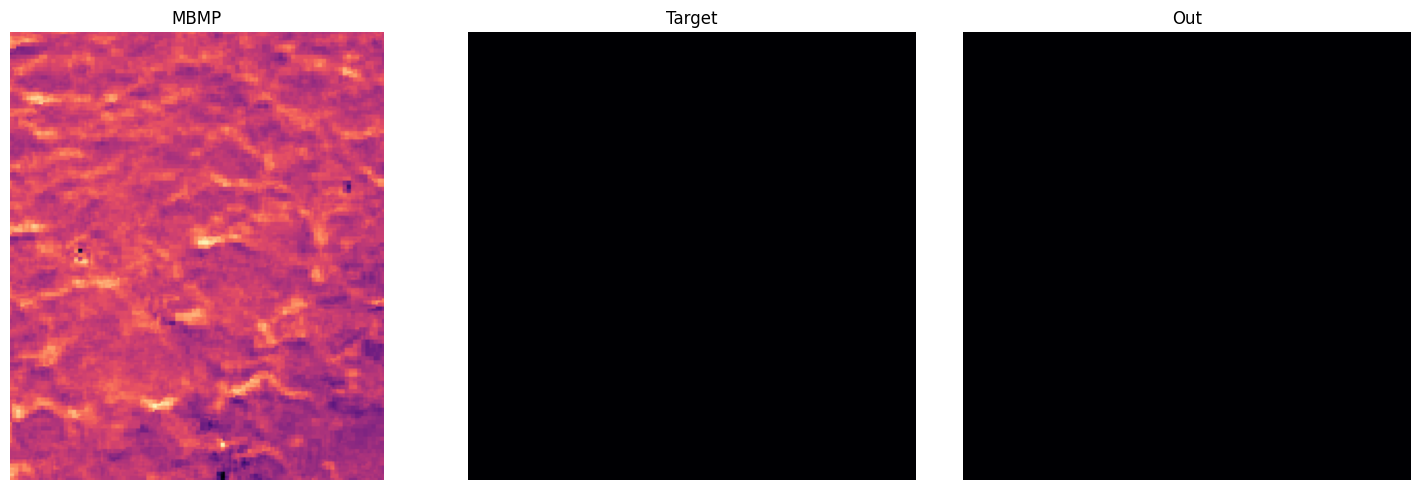

pos
3.968253952506928e-07


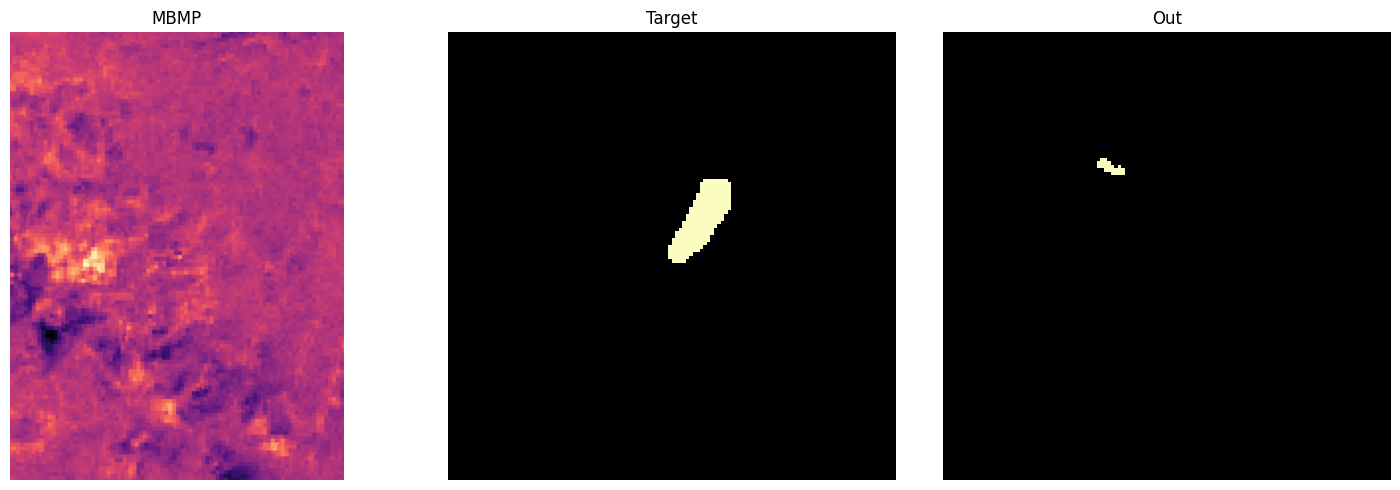

pos
2.3752969064719786e-07


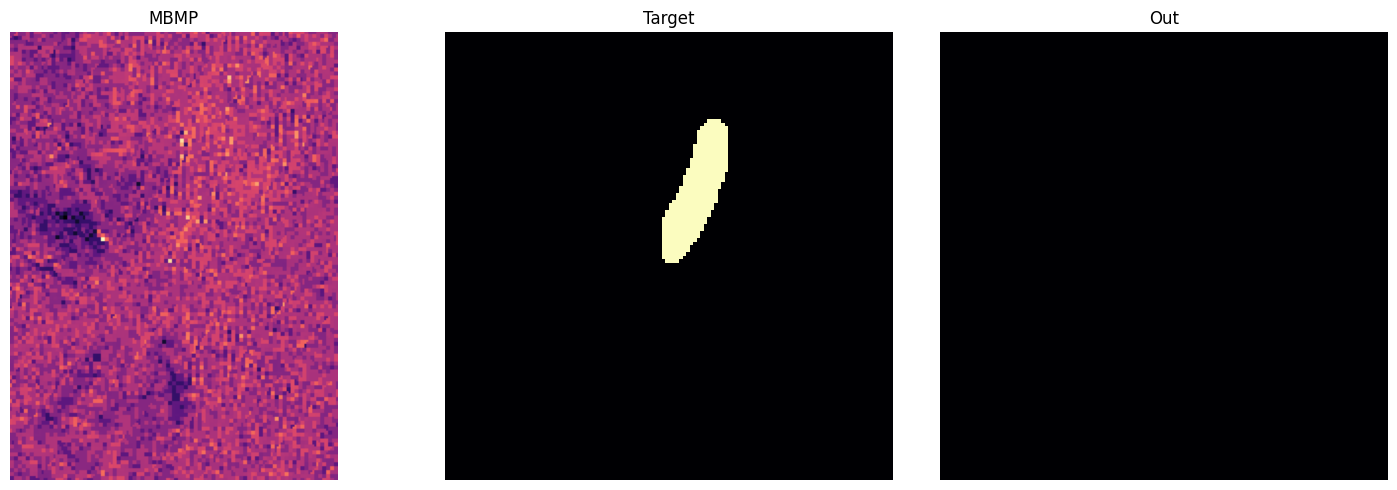

pos
51.90909095280991


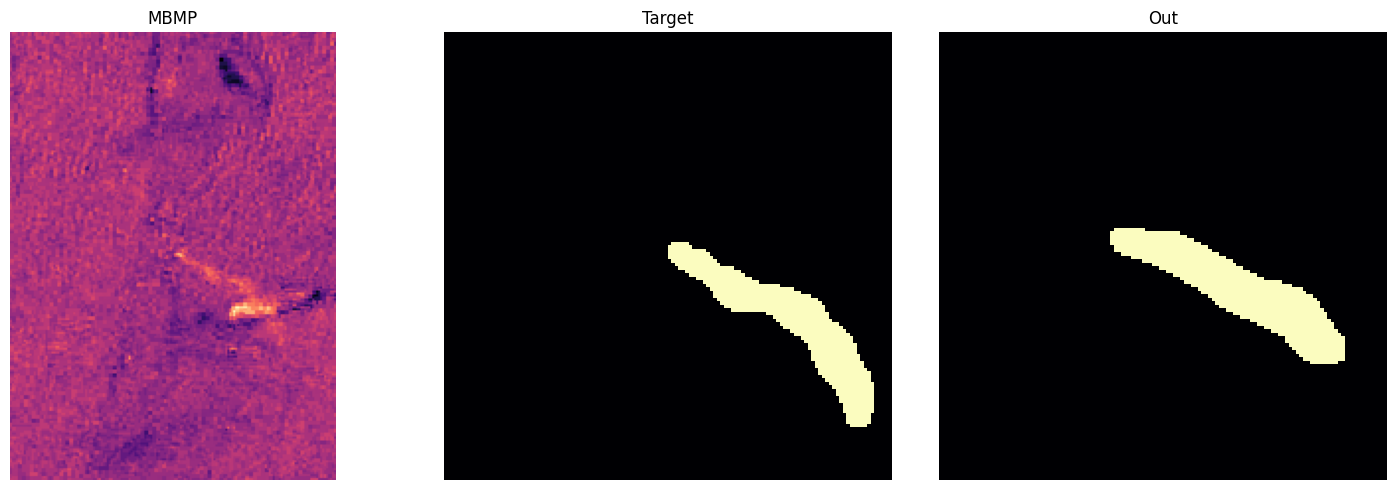

pos
29.333333467936505


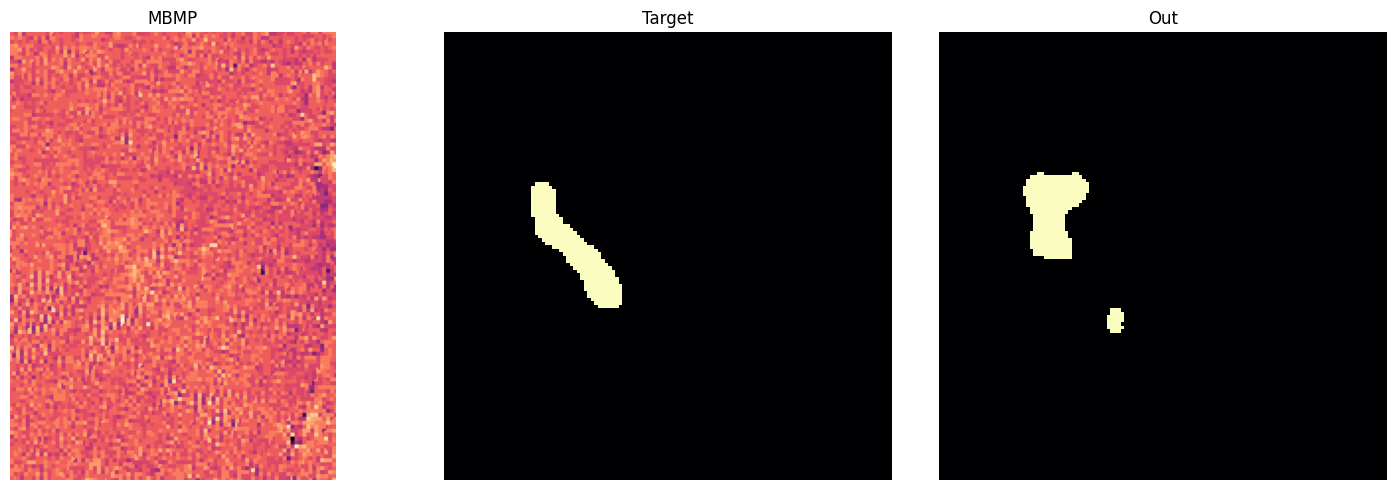

neg
100.0


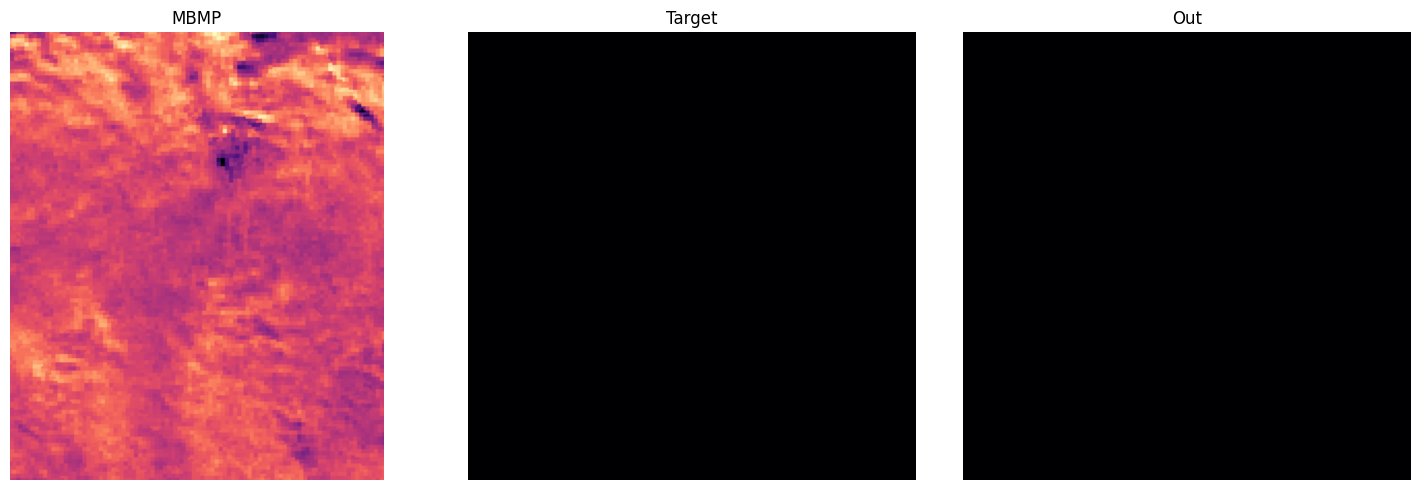

pos
17.862839046470754


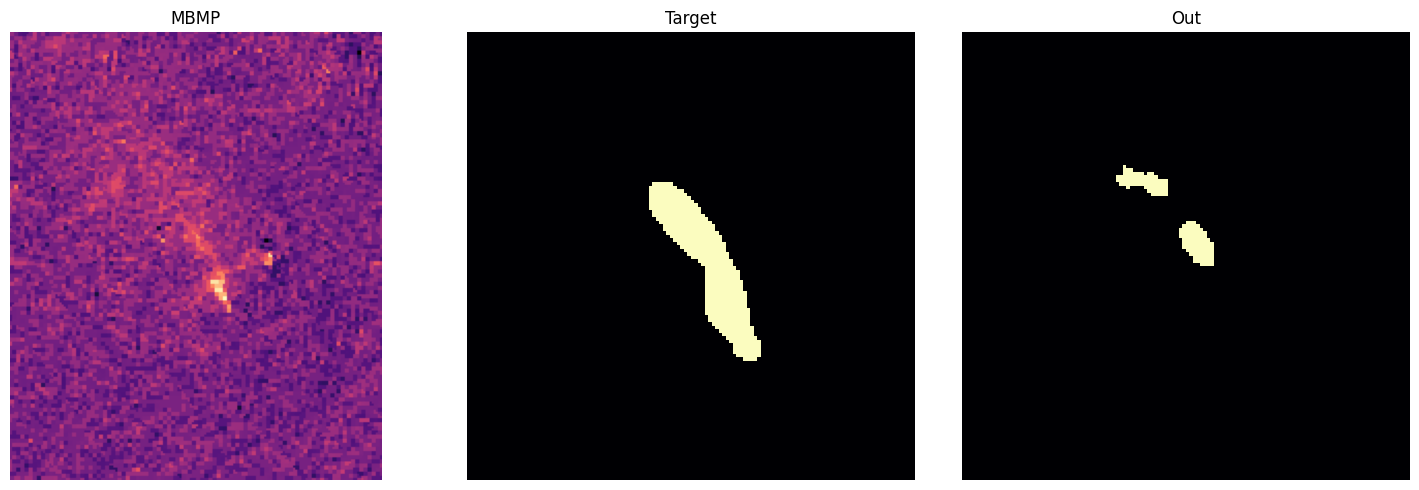

neg
100.0


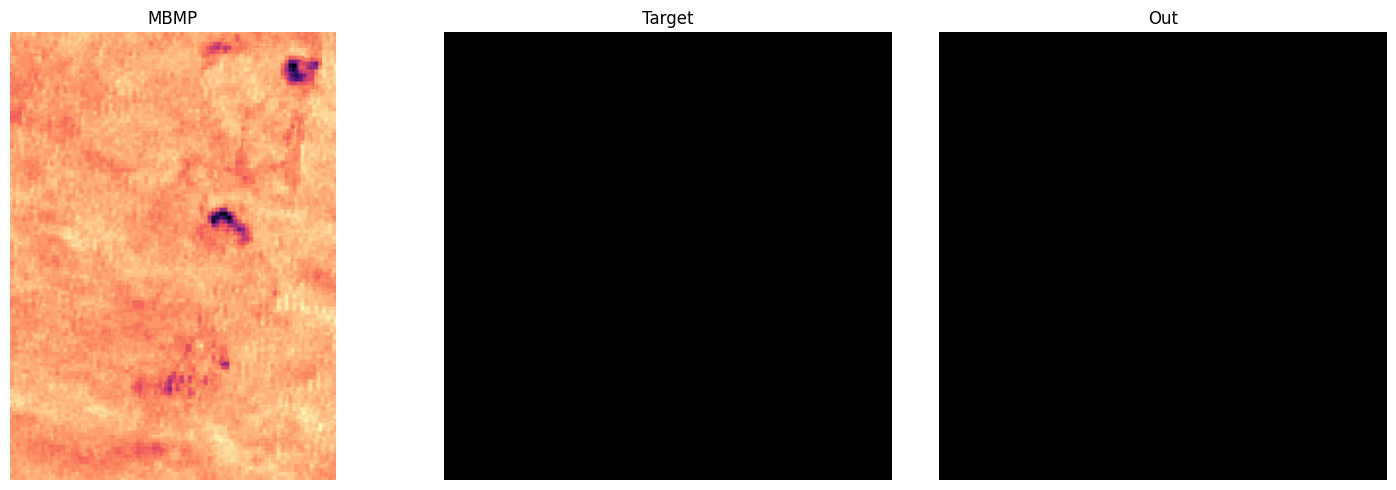

pos
68.49015320734118


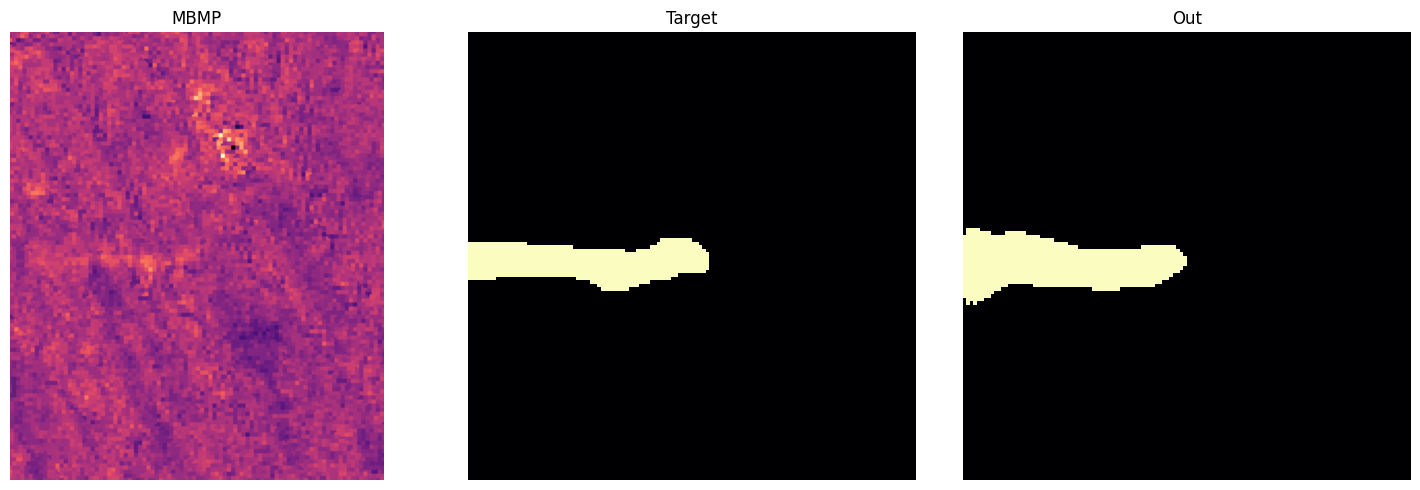

neg
5.617977496528216e-07


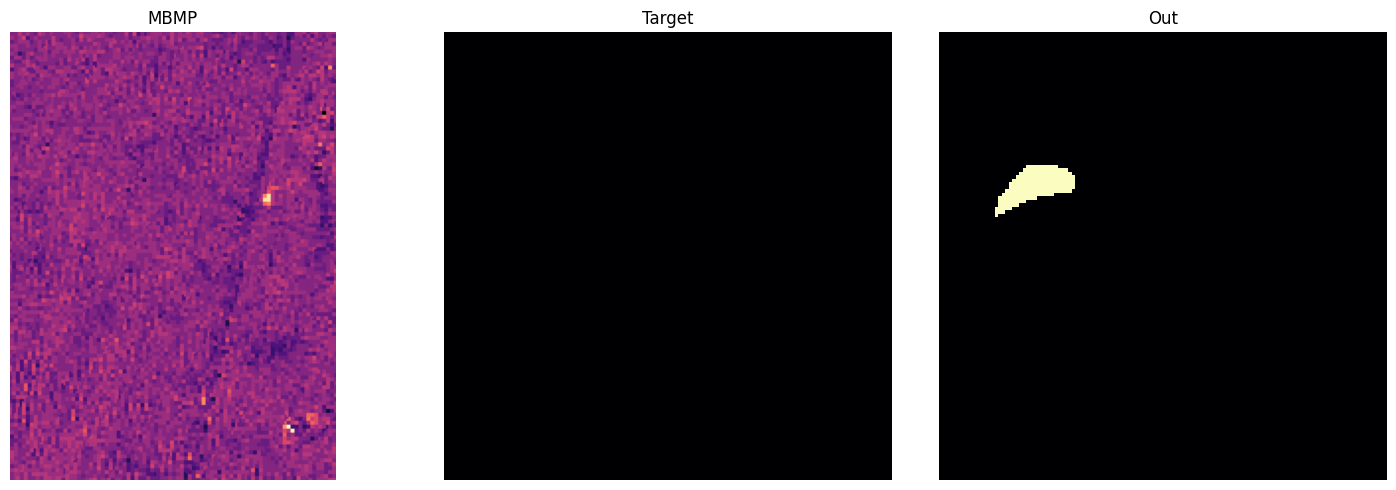

neg
5.617977496528216e-07


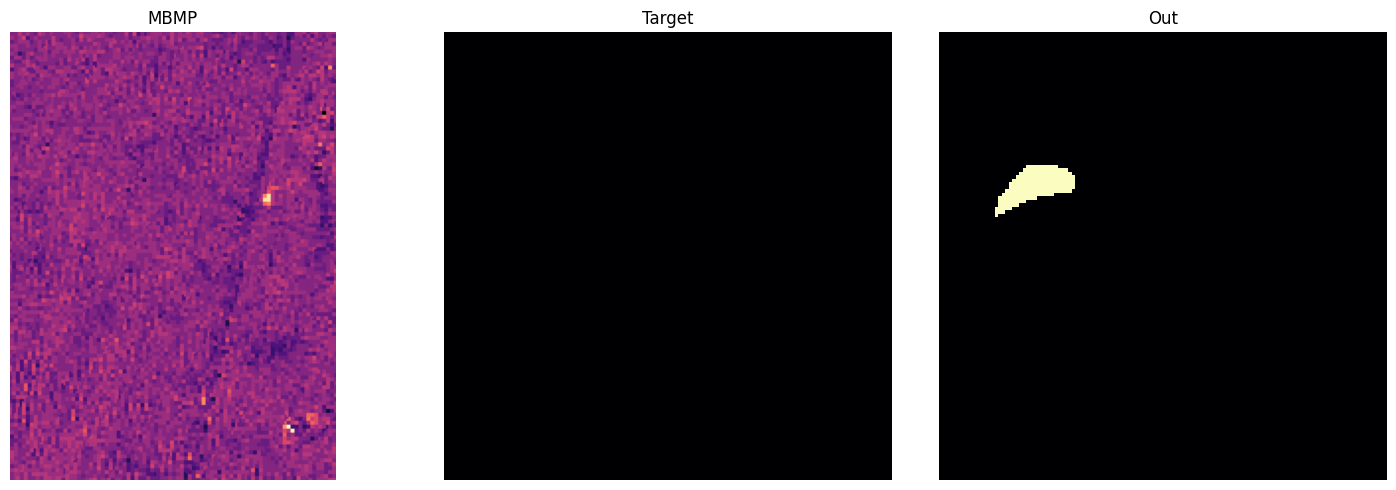

neg
100.0


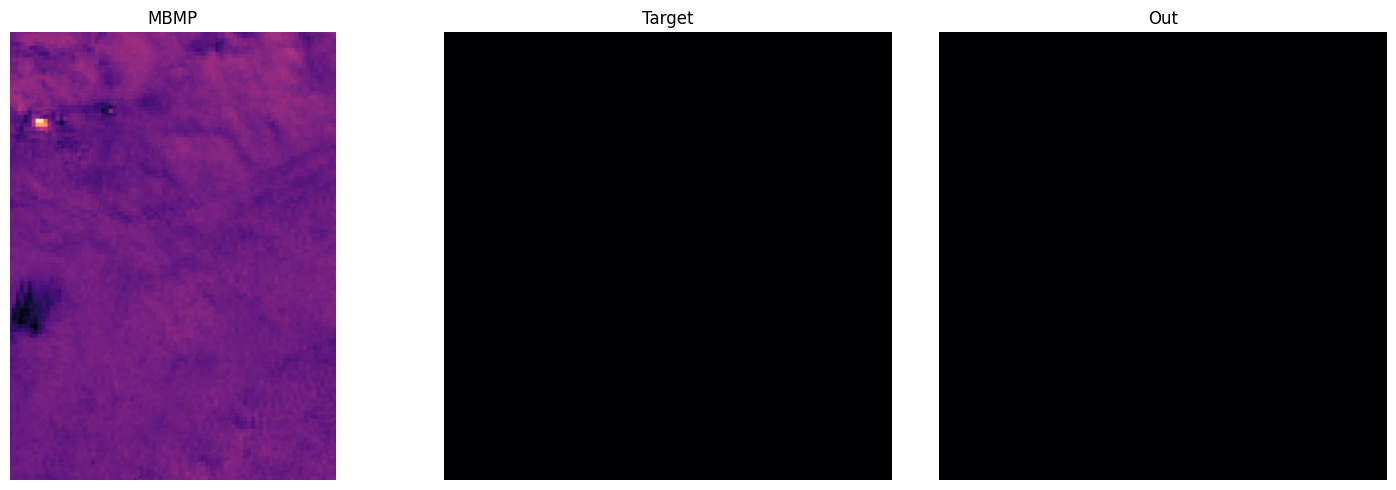

neg
3.2573289796178206e-07


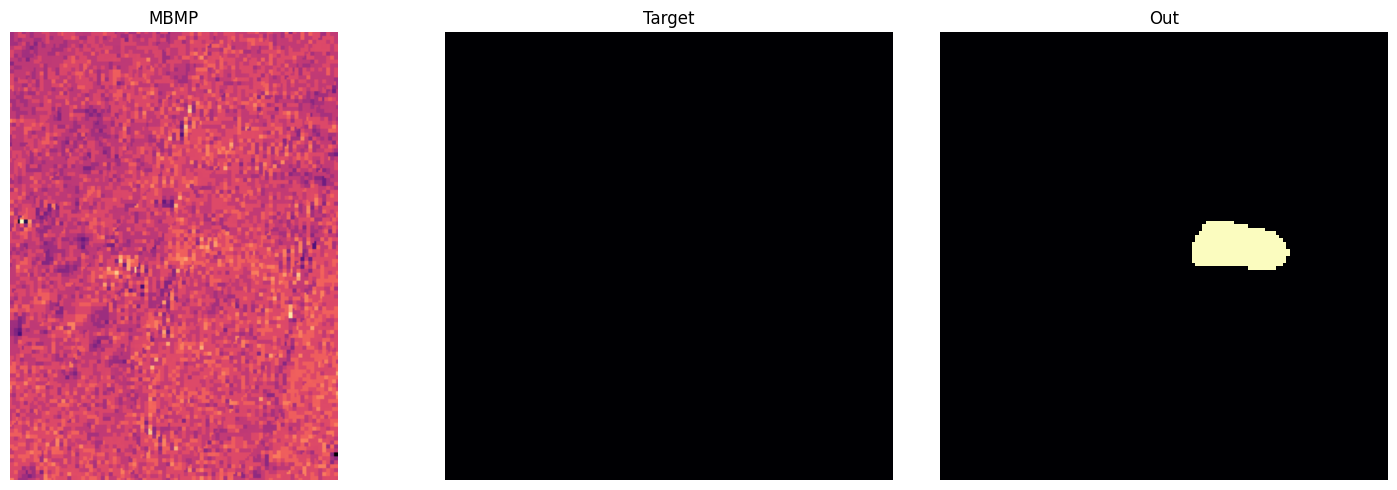

pos
44.89611567760061


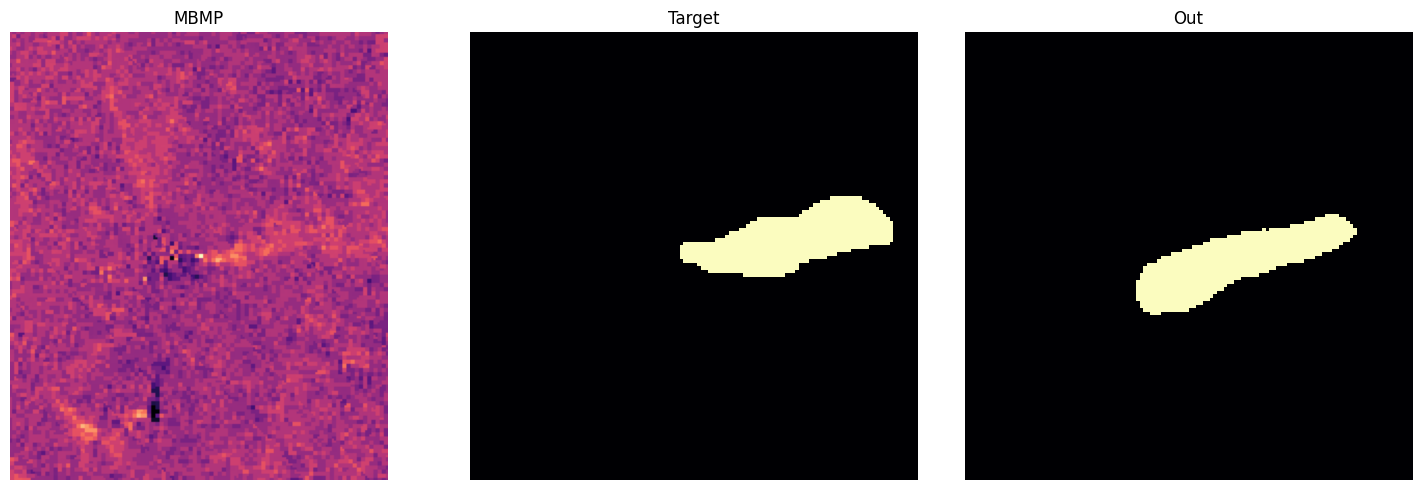

In [15]:
# from glob import glob

# visualize masks
samples = 250

# def visualize(idx):
    
for i in range(samples):
    idx = np.random.randint(0, samples)
#     idx = i

    file_paths = glob('/kaggle/input/ch4net-dataset/data/val/mbmp/*/{}.npy'.format(idx))
    for file in file_paths:
        category = file.split("/")[-2]
        print(category)
        image1 = np.load(file)
    image2 = np.load("/kaggle/working/eval_out/target_{}.npy".format(idx))
    image3 = np.load("/kaggle/working/eval_out/out_{}.npy".format(idx))

    # Squeeze the extra dimension if needed
    image1 = np.squeeze(image1)
    image2 = np.squeeze(image2)
    image3 = np.squeeze(image3)
#     print(image2.shape)
    
    eps = 1e-6
    pred = image3
    target = image2
    iou = (np.sum(np.logical_and(pred, target)) + eps) / (np.sum(np.logical_or(pred, target)) + eps) * 100
    
    print(iou)

#     print(image1.shape, image2.shape, image3.shape)
#     print(losses[idx])

    # Create a figure with 3 subplots side by side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display each image
    axes[0].imshow(image1, cmap='magma')
    axes[0].set_title('MBMP')
    axes[0].axis('off')  # Hide axis

    axes[1].imshow(image2, cmap='magma')
    axes[1].set_title('Target')
    axes[1].axis('off')  # Hide axis

    axes[2].imshow(image3, cmap='magma')
    axes[2].set_title('Out')
    axes[2].axis('off')  # Hide axis

    # Show the figure
    plt.tight_layout()
    plt.show()
    
    i = i + 1
    if(i==20): break
